
# Rapport sur la prévision des ventes

Ce document présente un modèle de prédiction ainsi que des pistes de solutions issues des analyses demandées par Moov AI.


## Analyse des données
Le fichier CSV fourni à Moov AI ne contient pas de valeurs manquantes. En examinant le tableau ci-dessous, on constate qu’il comporte 2 121 lignes et 21 colonnes.

In [1]:
from utils import get_data
data = get_data()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         2121 non-null   int64  
 1   Order ID       2121 non-null   object 
 2   Order Date     2121 non-null   object 
 3   Ship Date      2121 non-null   object 
 4   Ship Mode      2121 non-null   object 
 5   Customer ID    2121 non-null   object 
 6   Customer Name  2121 non-null   object 
 7   Segment        2121 non-null   object 
 8   Country        2121 non-null   object 
 9   City           2121 non-null   object 
 10  State          2121 non-null   object 
 11  Postal Code    2121 non-null   int64  
 12  Region         2121 non-null   object 
 13  Product ID     2121 non-null   object 
 14  Category       2121 non-null   object 
 15  Sub-Category   2121 non-null   object 
 16  Product Name   2121 non-null   object 
 17  Sales          2121 non-null   float64
 18  Quantity

### Variables de dates
On remarque dans le tableau ci-dessus que nous disposons d’une date de commande (`Order Date`) ainsi que d’une date de livraison (`Ship Date`). Bien qu’il s’agisse d’informations utiles, elles devront être transformées pour être utilisées dans notre modèle. À partir de ces deux variables, nous pourrons extraire les informations suivantes :

* La durée de livraison ;
* Le mois de commande ;
* L’année de commande.

### Variables de ventes
Le graphique ci-dessous montre la relation entre les différentes variables liées aux ventes. On y retrouve, entre autres, le profit réalisé pour chaque type de produit, le chiffre d’affaires total par produit, la quantité vendue ainsi que le rabais accordé. On constate qu’aucune relation évidente n’existe entre ces variables.

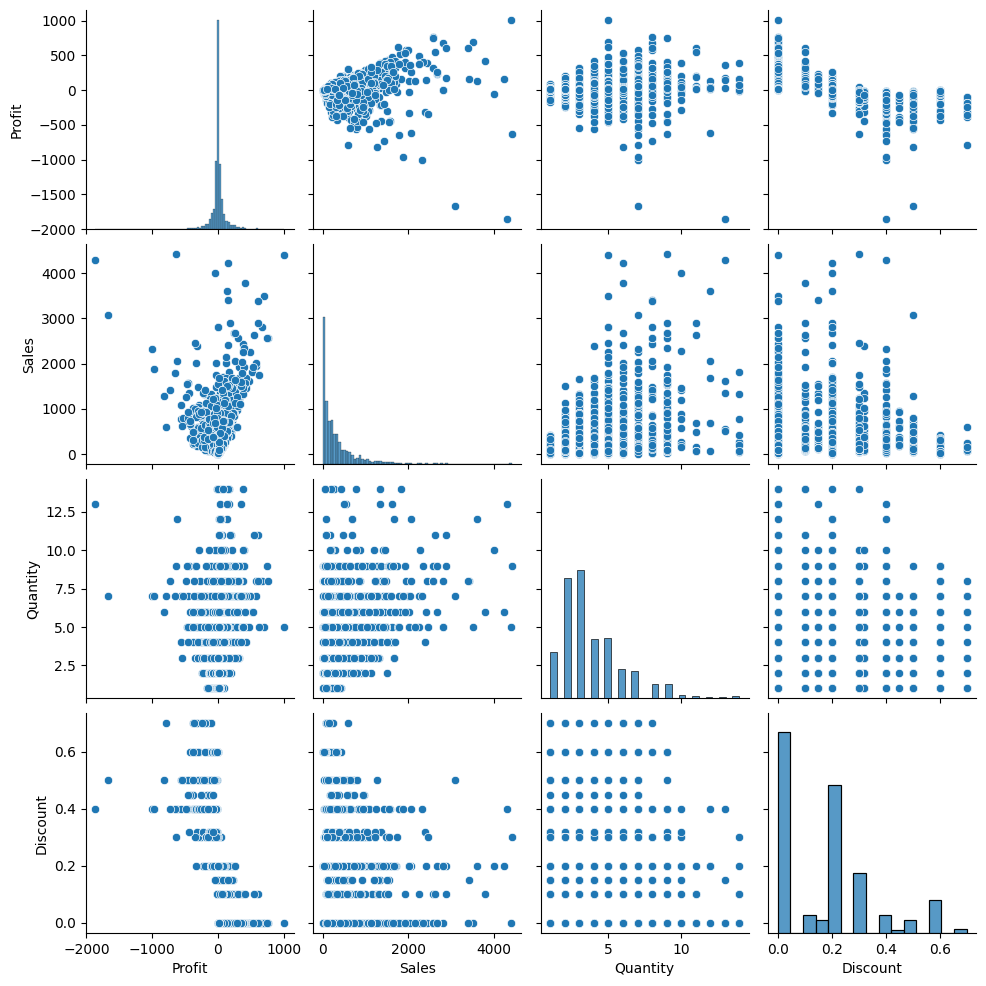

In [2]:
from utils import summary_graph
summary_graph(data)

Étant donné que le profit ne semble pas présenter de relation évidente avec le chiffre d’affaires, et que ces deux variables représentent des valeurs à maximiser et à prédire, une approche concrète consiste à les combiner. Nous suggérons donc d’utiliser le ratio profit/chiffre d’affaires. Cette métrique permettra au modèle de prédiction de mieux identifier les ventes réellement profitables, plutôt que de se focaliser sur des ventes élevées mais avec un rendement faible ou négatif.

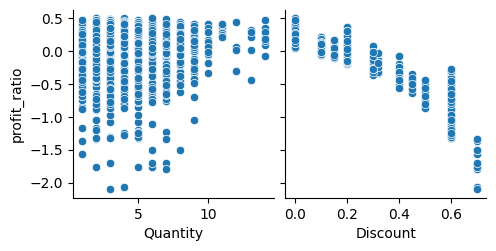

In [3]:
from utils import create_profit_ratio, ratio_graph
data["profit_ratio"] = create_profit_ratio(data)
ratio_graph(data)

Le graphique ci-dessus montre que le ratio profit/chiffre d’affaires des produits est une variable plus pertinente et qu’elle présente des relations plus significatives avec les autres variables liées aux ventes. On observe ainsi une relation négative entre le ratio de profit et le rabais accordé, ainsi qu’une relation positive avec la quantité vendue.

La variable `profit_ratio` sera donc celle que nous chercherons à prédire.

### Autres variables
Enfin, nous avons constaté que chaque ligne ne représente pas une transaction unique, mais plutôt une partie de transaction. Ce constat a été établi à l’aide de la variable Order ID. Cela pourrait offrir l’opportunité de réaliser un exercice de prévision des ventes, mais cela est moins pertinent pour comprendre comment augmenter les ventes.

Nous avons également écarté certaines variables du projet car elles pouvaient être redondantes. Le nom du client (`Customer Name`) et l’identifiant du client (`Customer ID`) représentent la même information. Nous avons donc supprimé le nom du client.

De la même manière, le nom du produit (`Product Name`) et l’identifiant du produit (`Product ID`) représentent également la même information. Dans ce cas, nous avons supprimé l’identifiant du produit, car il ne semblait pas unique et aurait pu biaiser les interprétations du modèle.

Enfin, les variables représentant le type de catégorie de produit et le pays sont toutes deux constantes. Elles n’apportent donc aucune valeur ajoutée et n’ont pas été incluses dans le modèle.

# Transformation des données

À la lumière des analyses précédentes, le modèle que nous proposons créera trois nouvelles variables: 
* Durée de livraison, qui sera standardisée,
* Mois de la commande, qui sera transformé en variable binaire,
* Année de la commande, qui sera transformée en variable binaire.

Les variables suivantes seront retirées du modèle:
* Pays,
* Catégorie de produit.

Les variables numériques seront standardisées afin que leurs valeurs soient comparables et situées sur des échelles similaires.

Les variables catégorielles seront transformées en variables binaires pour faciliter leur interprétation par le modèle.

Enfin, nous préparerons la variable à prédire pour qu’elle représente le ratio profit/chiffre d’affaires.

In [4]:
from model import preprocessor
preprocessor

,transformers,"[('date_features', ...), ('numerical_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,start_col,'Order Date'
,end_col,'Ship Date'
,transformers,"[('scaler', ...), ('encoder', ...)]"


Le graphique ci-dessus illustre les différentes étapes de transformation des données. À gauche, on observe les modifications apportées aux variables de dates. Au centre, les transformations appliquées aux variables numériques sont présentées. Enfin, à droite, on retrouve les transformations effectuées sur les variables catégoriques.

# Modèle choisi

Nous avons opté pour un modèle basé sur les arbres : le Gradient Boosting Regressor. Étant donné le nombre important de produits, il nous fallait un modèle capable de prendre en compte ou d’exclure chacune des interactions présentes dans la base de données. Ce modèle offre également la flexibilité nécessaire pour capturer les relations non linéaires entre les variables. Enfin, la présence de variables numériques et catégorielles dans la base de données ne constitue pas un obstacle pour ce type de modèle.

In [5]:
from model import estimator
estimator

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('date_features', ...), ('numerical_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Le graphique ci-dessus montre qu’après les différentes transformations, les données seront directement utilisées comme entrée pour le modèle Gradient Boosting Regressor.

Enfin, afin d’éviter le surapprentissage, le modèle sera évalué à l’aide de la validation croisée, une méthode qui permet de réduire le risque que le modèle s’ajuste trop aux données d’entraînement.

In [20]:
from model import model
model

,estimator,Pipeline(step...Regressor())])
,param_grid,"{'model__learning_rate': [0.01, 0.1, ...], 'model__max_depth': [3, 4, ...], 'model__n_estimators': [100, 200]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('date_features', ...), ('numerical_features', ...), ...]"


Le graphe ci-dessus montre le modèle complet.
1. La transformation des données (`preprocessor`)
2. Le modèle (`estimator`)
3. La validation croisée (`GridSearchCV`).

# Entraînement du modèle

Nous avons divisé la base de données en deux parties selon un ratio de 80/20. La plus grande portion sera utilisée pour entraîner le modèle, tandis que la seconde servira à le valider.

In [27]:
from utils import create_X_y
X_train, X_test, y_train, y_test = create_X_y(data)

Nous entrainons le modèle sur les données `_train`.

In [ ]:
import os
from utils import saving_model, load_model

filename = "profit_ratio_gb_model"
if not os.path.exists("models/profit_ratio_gb_model.joblib"):
    model.fit(X_train, y_train)
    saving_model(model=model.best_estimator_, name=filename)
    #(je suis désolé, je n'arrive pas à sauvegarder le modèle. Celui-ci n'est pas long à rouler.)
else:
    model = load_model(filename)

Model saved.


## Interprétation
Le modèle semble bien prédire le ratio profit/chiffre d’affaires. Un magasin peut désormais estimer le profit sur vente en fonction de la quantité, du rabais accordé et des autres variables importantes.

Les parties prenantes peuvent tester directement quel niveau de rabais et quelle quantité vendue peuvent conduire à une transaction rentable.

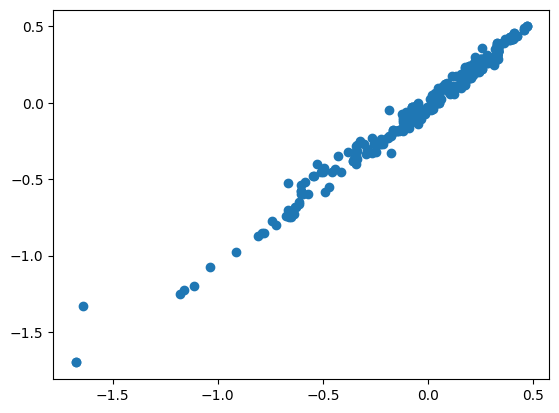

In [ ]:
import matplotlib.pyplot as plt
prediction = model.best_estimator_.predict(X_test)
plt.scatter(prediction, y_test)

# Solution ML et dégradation de la performance

Comme mentionné précédemment, la solution proposée est rapide, puissante et efficace. Il n’est désormais plus nécessaire d’entraîner le modèle de manière fréquente.

Cependant, le modèle peut voir ses performances se dégrader si de nouvelles valeurs de produits, de clients ou même de magasins sont introduites dans l’organisation. Dans ce cas, il est essentiel de réentraîner le modèle afin qu’il prenne en compte ces nouvelles entités ou valeurs. Sans réentraînement, le modèle ne saura pas comment traiter des valeurs qu’il n’a jamais rencontrées.

# Intégration de l'IA générative

La suggestion que nous proposons pour les magasins est la suivante : créer une plateforme web permettant d’intégrer le modèle de machine learning. Le magasin n’aurait qu’à fournir les informations d’une vente, telles que le nom du client, le nom du produit, la quantité, le prix, le rabais appliqué, etc. L’IA pourrait alors agir comme un filtre pour identifier les ventes peu avantageuses et proposer des recommandations sur des variables comme la quantité ou le rabais autorisé afin de maximiser le profit.

Voici un exemple de prompt qui pourrait soutenir cette approche :

Vous êtes un assistant intelligent spécialisé en optimisation du profit des ventes pour une compagnie de détail.

Contexte : 
- Nous disposons d’un modèle de prédiction du ratio profit sur vente.
- Chaque magasin peut saisir les informations d’une vente : nom du client, produit, quantité, prix, rabais appliqué, date de livraison, etc.
- L’objectif est de maximiser le profit de chaque vente tout en restant conforme aux politiques de l’entreprise.

Tâches attendues :
1. Évaluer si la vente proposée est avantageuse ou non pour la compagnie.
2. Proposer des ajustements pour maximiser le profit : quantité, rabais autorisé, prix recommandé, ou autre variable pertinente.
3. Expliquer brièvement l’impact de chaque recommandation sur le profit.
4. Fournir des conseils clairs, exploitables et compréhensibles par le personnel du magasin.

Format de sortie : Liste structurée avec chaque recommandation et sa justification.

# Autres approches
Comme mentionné précédemment, la variable `Order ID` aurait permis de transformer la base de données différemment. Étant donné la contrainte de temps allouée à cet exercice, j’ai choisi d’opter pour une approche plus simple.

Toutefois, un modèle ARIMA ou d’autres méthodes de prévision pour séries temporelles auraient également été valides pour la prévision des ventes. Le temps nécessaire pour transformer la base de données pour ces modèles aurait toutefois été trop important.